#Radiometer Experiment 2 - Stability

## Experimental setup

![Lab Setup](https://lh5.googleusercontent.com/-MQnV1zYcQWA/VKmzjJYKqYI/AAAAAAAB84E/1qX4x5rKVAQ/w977-h733-no/20150104_154121.jpg)

Experiment 2 is used to help us establish that the system is stable is not fluctating greatly.  The experiment uses a 50 ohm matched load that is attached to the radiometer.  This matched load is then submerged into Liquid Nitrogen at ~ 77 K, for an extended period of time.   

## Software Defined Radio setup
The Software Defined Radio uses a N200 SDR with GNURadio running a custom code for the radiometer.  This program includes a GUI that allows for us to monitor the radiometer as well as control many of the properties of the radiometer such as frequency, bandwidth and integration time.  
![GNURadio Program](https://lh6.googleusercontent.com/-8X3Tm3wyh-k/U-mZk_99UcI/AAAAAAAB5Vk/-Up_76efr7E/w1214-h759-no/Lab_0_Spectrum.png)

The program stores the data as a binary format which we can then load into a program such as Matlab or Python.  

## Square-law detector
For this experiment the square-law detector is not used.  We are only concerned that the SDR is stable.
- - -

The following code reads in the data recorded and then graphs the information

Import Needed functions

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
import numpy
import scipy.io as sio
import csv

Use this to set the filename for the data file and CSV Calibration file.  We are not interested in square-law data nor do we need to calibrate the data as we are looking at overall trends.

In [3]:
tpr = 'SDR_TPR_EXP2.dat'

Uses SciPy to open the binary file from GNURadio

In [4]:
f = scipy.fromfile(open(tpr),dtype=scipy.float32)

Because of the valve function in GNURadio, there are zeros that get added to the file.  We want to trim out those zeros.

In [5]:
f = numpy.trim_zeros(f)

Create an index array for plotting.  Also, since we know the interval the data is taken, we can convert this to an actual time.

In [6]:
y = numpy.linspace(0,(len(f)*.5),numpy.size(f))

## Plot the data

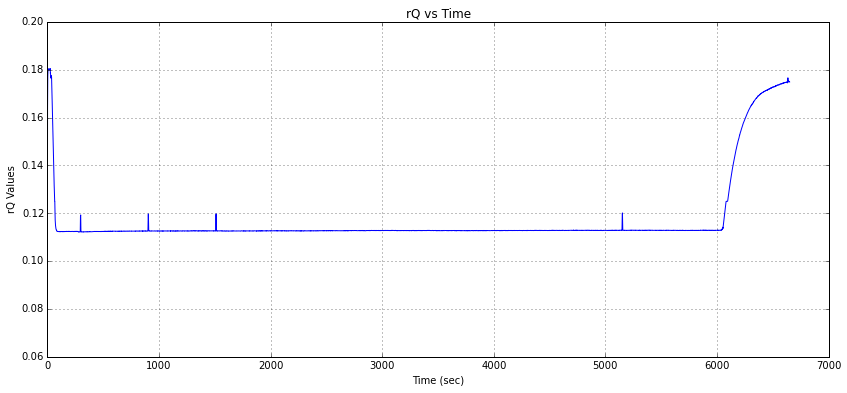

In [7]:
fig = plt.figure(figsize=(14,6), dpi=100)
plot(y,f)
xlabel('Time (sec)')
ylabel('rQ Values')
title('rQ vs Time')
grid(True)

## Analyzing the data

We want to make sure the data is consistent over a period of time.  To do that we can look at the standard deviation of the data, specifically during the time that it is submerged in LN2.  

It can be seen in the graph above that we had a few spikes in the data.  In each case the data returned to normal values.  These spikes are probably cuased by an external influence, such as stray RF or slight fluctation in power.  However, we do have a solid one hour period that is free from any spikes.  We therefore focused on this area of the data to do our analysis.

- - -

We know the data range that we want to look at, so let's trim out the rest of the data.

In [8]:
f = f[(1520*2):]
f = f[:(5240*1.37)]
y = y[(1520*2):]
y = y[:(5240*1.37)]

Now Plot this new array

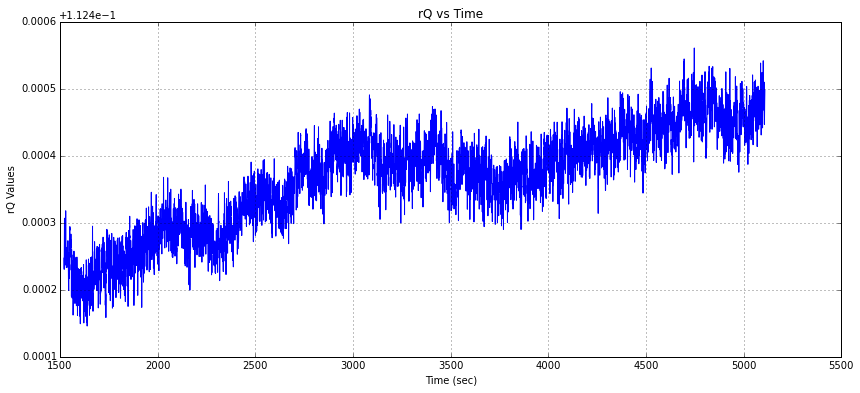

In [9]:
fig = plt.figure(figsize=(14,6), dpi=100)
plot(y,f)
xlabel('Time (sec)')
ylabel('rQ Values')
title('rQ vs Time')
grid(True)

Now let's do a standard deviation on this data and we also want to generate the points to do a polynominal fit to the data.

In [10]:
a = numpy.std(f)
print a
p = numpy.polyfit(y,f,2)
print p

7.6417e-05
[ -1.38429812e-11   1.55238686e-07   1.12418706e-01]


Since there is some noise in the signal, even with the integration there, let's do a polynominal fit to the data.  For the next graph we are using a second order polynominal fit to the data.

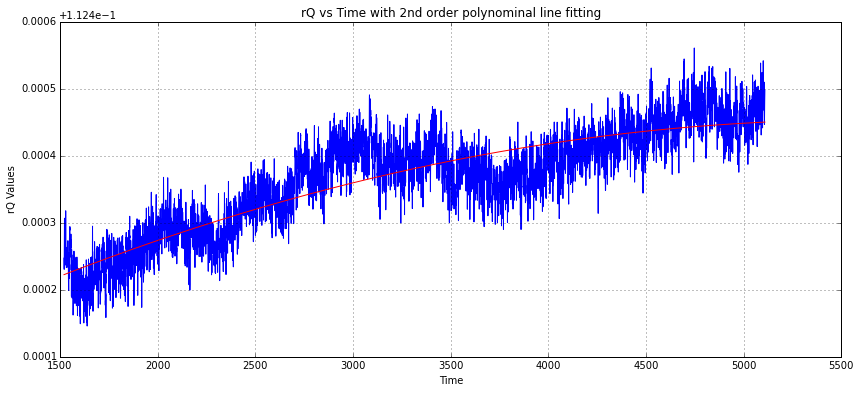

In [11]:
fig = plt.figure(figsize=(14,6), dpi=100)
plot(y,f)
plot(y,p[0]*y*y+p[1]*y+p[2],'r-')
xlabel('Time')
ylabel('rQ Values')
title('rQ vs Time with 2nd order polynominal line fitting')
grid(True)

Let's now look at the standard deviation with the data.  First we will smooth out the line and then plot the standard deviation on top of that line.

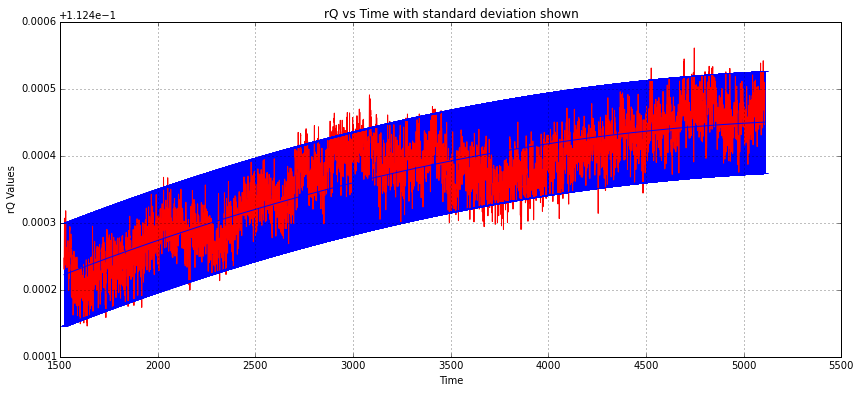

In [12]:
fig = plt.figure(figsize=(14,6), dpi=100)
b = p[0]*y*y+p[1]*y+p[2]
plot(y,f,'r-')
errorbar(y,b,a)
xlabel('Time')
ylabel('rQ Values')
title('rQ vs Time with standard deviation shown')
grid(True)

- - -
# Stability analysis

Stability is controlled primarily by the gain in the radiometer and is also affected by the overall system temperature as well.  It can be seen in the equation below how Gain, changes in gain and the system temperature affect our changes to gain and thus our stability in the radiometer.

$$\Delta T_{G}=T_{sys} \left(\frac{\Delta G}{G}\right)$$

We assume that our system temperature or $T_{sys}$ is constant.  Therefore our change in gain is our main driving force behind stability.  Changes to gain can happen due to two reasons.  First, we may have changes in the voltage that is being provided to the LNAs.  In our case, we are using a lab grade power supply where voltage ripple and changes should be tightly regulated.  Second, the physical temperature of the LNA also affects the amount of gain it provides.  This is harder to control, but in a lab environment can be at least monitored.  While the radiometer we are using does have thermal electric coolers that can also be used to regulate the temperature of the LNAs.  However they were disabled for these experiments due to suspicion that they were causing possible interference to the LNAs.  

By looking at the data above we have a standard deviation of $7.6 x 10^-6$ and an overal change of roughly .0003 for the rQ value.  Using calibrated data this roughly a change of .6 Kelvin.  This is well within our expected $\Delta T$ of 1 Kelvin.